In [2]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest, uncertainty_subtraction as us, calculate as calc

from astropy.table import hstack
import numpy as np
import matplotlib.pyplot as plt

#collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

#master_hvcs = hvcl.load_HVCs([], [], "../data_processed/toy_model/toy_hvcs/", toy_override=True)

bigger_results = ct.read_processed("../data_processed/results_post_RM")
#big_results_filtered = ct.read_processed("../data_processed/toy_model/results_final_filtered")
bigger_results

Name,Significant,Sigma [diff],KS-EDF,KS-EDF Unc,Var. Sub.,Var. Sub. Unc,Wgt. Mean,Wgt. Mean Unc
str15,bool,float64,float64,float64,float64,float64,float64,float64
G038.7-37.3-241,True,-7.5559356070774975,2.5627908299515854,1.88412670065244,-1.148502189258788,1.1190574845977512,1.1674538475147485,1.0657860485189359
G038.8-33.2-261,True,-3.6485845077294528,1.2506166058012396,1.2600487397765774,-0.3648584367043805,0.7493263494623595,1.1282560140867086,0.704252829047231
G043.4-30.4-230,True,-2.3590579203581576,2.3022435957955607,1.7513719025187582,-0.30911793851032654,0.9339203862139179,1.6134534179160942,0.9265650673579282
G133.5-75.6-294,True,-6.847658270169869,1.7903369992621851,1.5393504772675175,-1.2391001157644457,1.2899811105917645,0.7605065031791882,1.2709874958726377
G261.5-34.5+237,True,6.542074154087057,7.082428471099994,8.702837736871976,3.8843565899473718,4.5469259746231945,3.39398037916118,4.392547110718694
G262.4-26.2+143,True,-28.767857863402234,5.011555956863386,6.126485831373338,-10.931786009402783,8.641045534926972,3.9435900254244936,2.770054074410643
G264.6-53.3+224,True,0.35850194470109464,-2.1209304891602234,3.442969935077107,0.11352562020407306,2.5798847296388714,-2.1793169469598506,2.2611730951018925
G267.1-38.4+263,True,8.787618562445854,9.414161962255921,6.694791528587984,3.8382701308235028,3.729217719026222,3.4833753468970174,3.2935590374354797
G271.6-48.4+297,True,0.7298893876279617,0.591631031100386,1.9838466678920055,0.12607179978284094,1.2372407781992796,0.07668164585606313,1.2092050342754088


In [2]:
from astropy.table import Table

def post_process_magnetic_fields(master_hvcs, data):
    name_list = []
    sign_list = []
    uner_list = []

    ksl_list = []
    uns_list = []
    wgm_list = []

    ksl_unc_list = []
    uns_unc_list = []
    wgm_unc_list = []

    for i in range(len(master_hvcs)):
        name_list.append(master_hvcs[i]["HVC"]["Name"])
        sign_list.append(data[i]["Significant"])
        uner_list.append(data[i]["Sigma [diff]"])

        #val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Statistic_diff"], data[i]["KS unc"])[0]
        ksl_list.append( data[i]["Statistic_diff"])
        ksl_unc_list.append(data[i]["KS unc"])

        #val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Sigma [diff]"], data[i]["Sigma unc"])[0]
        uns_list.append(data[i]["Sigma [diff]"])
        uns_unc_list.append(1)#data[i]["Sigma unc"])

        #val = calc.B_virt(master_hvcs[i]["HVC"]["NH"], master_hvcs[i]["HVC"]["e_NH"], data[i]["Average [diff]"], data[i]["Avg Unc [diff]"])[0]
        wgm_list.append(data[i]["Average [diff]"])
        wgm_unc_list.append(data[i]["Avg Unc [diff]"])
    
    t = Table()
    t.add_columns([name_list, sign_list, uner_list, ksl_list, ksl_unc_list, uns_list, uns_unc_list, wgm_list, wgm_unc_list], names=["Name", "Significant", "Sigma [diff]", "KS-EDF", "KS-EDF Unc", "Var. Sub.", "Var. Sub. Unc", "Wgt. Mean", "Wgt. Mean Unc"])
    return t

finals = post_process_magnetic_fields(master_hvcs, bigger_results)
filtered = us.filter_significant(finals, sigma_filter=False)


In [3]:
results = ct.write_processed(filtered, "../data_processed/toy_model/results_post")

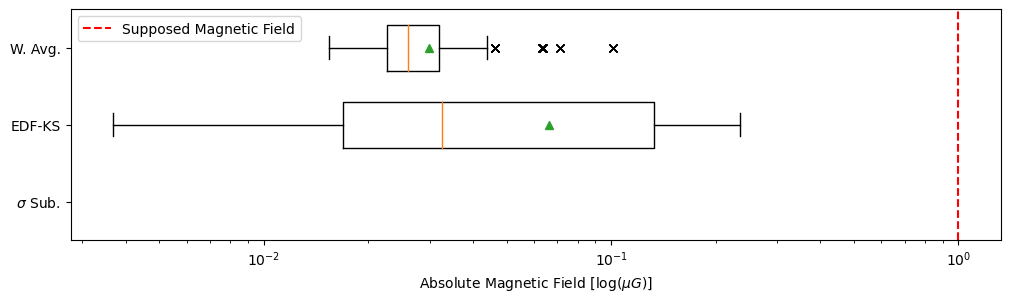

In [5]:
dic = {r"$\sigma$ Sub.": abs(filtered["Var. Sub."]), "EDF-KS": abs(filtered["KS-EDF"]), "W. Avg.": abs(filtered["Wgt. Mean"])}
plt.figure(figsize=(12,3))
plt.boxplot(dic.values(), labels=dic.keys(), vert=False, showmeans=True, widths=0.6, sym="x")
plt.axvline(1, c='r', linestyle='--', label=r"Supposed Magnetic Field")
plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.xscale('log')
#plt.xlim(0.1, 15)
plt.legend()
plt.show()

In [8]:
print(100*len(filtered)/len(finals))
print(len(filtered))

12.630208333333334
388


In [6]:
from scipy.stats import linregress

results_stack = us.filter_significant(hstack([finals, collated_data['HVCs']]))

Var. Sub. slope: -12.572703226550608
KS-EDF slope:    -26.856579544439352
Wgt. Avg. slope: -3.8528375397646086
Var. Sub. x-int: 1.6735447035564783
KS-EDF x-int:    1.5285419214826035
Wgt. Avg. x-int: 4.336392407460455
Var. Sub. R^2:   0.059632232139626914
KS-EDF R^2:      0.05764859225859303
Wgt. Avg. R^2:   0.007095225964694864


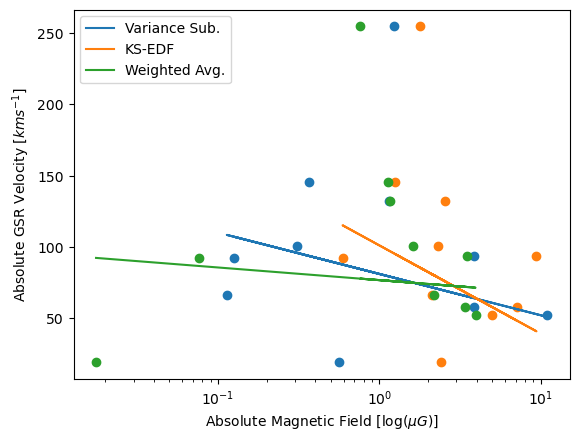

In [7]:
plt.scatter(abs(results_stack["Var. Sub."]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["KS-EDF"]), abs(results_stack['VGSR']))
plt.scatter(abs(results_stack["Wgt. Mean"]), abs(results_stack['VGSR']))

plt.xscale('log')
#plt.xlim(0.1, 15)

pf10, pf11, r_value1, p_value1, std_err1 = linregress(np.log(abs(results_stack["Var. Sub."])), abs(results_stack['VGSR']))
pf20, pf21, r_value2, p_value2, std_err2 = linregress(np.log(abs(results_stack["KS-EDF"])), abs(results_stack['VGSR']))
pf30, pf31, r_value3, p_value3, std_err3 = linregress(np.log(abs(results_stack["Wgt. Mean"])), abs(results_stack['VGSR']))

plt.plot(abs(results_stack["Var. Sub."]), pf10 * np.log(abs(results_stack["Var. Sub."])) + pf11, label="Variance Sub.")
plt.plot(abs(results_stack["KS-EDF"]), pf20 * np.log(abs(results_stack["KS-EDF"])) + pf21, label="KS-EDF")
plt.plot(abs(results_stack["Wgt. Mean"]), pf30 * np.log(abs(results_stack["Wgt. Mean"])) + pf31, label="Weighted Avg.")

plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.ylabel(r"Absolute GSR Velocity [$km s^{-1}$]")
plt.legend()

print(r"Var. Sub. slope: "+str(pf10))
print(r"KS-EDF slope:    "+str(pf20))
print(r"Wgt. Avg. slope: "+str(pf30))

#print(r"Var. Sub. y-int: "+str(pf11))
#print(r"KS-EDF y-int:    "+str(pf21))

print(r"Var. Sub. x-int: "+str((60-pf11)/pf10))
print(r"KS-EDF x-int:    "+str((60-pf21)/pf20))
print(r"Wgt. Avg. x-int: "+str((60-pf31)/pf30))

print(r"Var. Sub. R^2:   "+str(r_value1**2))
print(r"KS-EDF R^2:      "+str(r_value2**2))
print(r"Wgt. Avg. R^2:   "+str(r_value3**2))

plt.show()

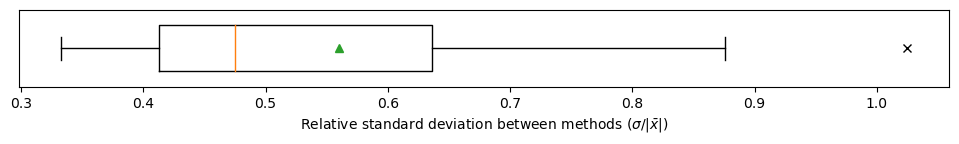

In [8]:
plt.figure(figsize=(12,1))

lists = [abs(big_results_filtered["Sigma [diff]"]), abs(big_results_filtered["Statistic_diff"]), abs(big_results_filtered["Average [diff]"])]

std = np.std(lists, axis=0)/np.mean(lists, axis=0)

plt.boxplot(std, vert=False, showmeans=True,widths=0.6, sym="x")
plt.yticks([])
#plt.axvline(8, c='r', linestyle='--', label=r"Smith Cloud")
plt.xlabel(r"Relative standard deviation between methods ($\sigma/|\bar{x}|$)")
#plt.xscale('log')
#plt.xlim(0.1, 15)
#plt.legend()
plt.show()

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap, collation_tools as ct
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd, KStest, uncertainty_subtraction as us, calculate as calc

from astropy.table import hstack
import numpy as np
import matplotlib.pyplot as plt

results = ct.read_processed("../data_processed/results_post_RM")

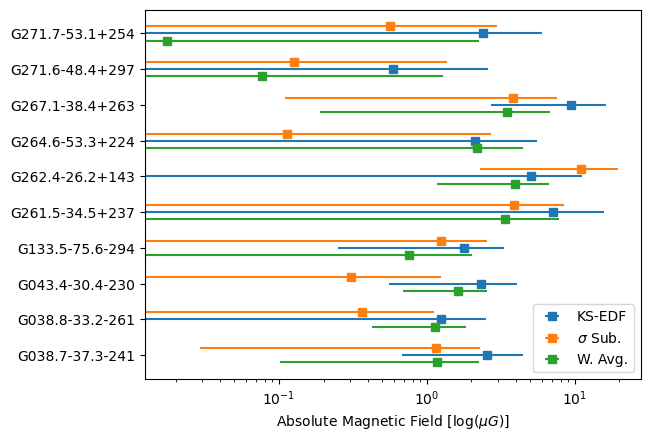

In [41]:
plt.xscale('log')
fake_axis = np.array(range(len(results["Name"])))
plt.errorbar(np.abs(results["KS-EDF"]), fake_axis, xerr=results["KS-EDF Unc"], fmt='s', label="KS-EDF")
plt.errorbar(np.abs(results["Var. Sub."]), fake_axis+0.2, xerr=results["Var. Sub. Unc"], fmt='s', label=r"$\sigma$ Sub.")
plt.errorbar(np.abs(results["Wgt. Mean"]), fake_axis-0.2, xerr=results["Wgt. Mean Unc"], fmt='s', label="W. Avg.")
plt.yticks(fake_axis, labels=results["Name"].data)#, rotation=45, ha='right')
plt.xlabel(r"Absolute Magnetic Field [log($\mu G$)]")
plt.legend(loc="lower right")
plt.show()